In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.colors as mcolors
import seaborn as sns
import math

# import warnings
# warnings.filterwarnings('ignore')

from datetime import timedelta

In [2]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils

# Load FastF1's dark color scheme
ff1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False,
                          color_scheme='fastf1')

In [3]:
# Enable the cache by providing the name of your cache folder
cache_path = '/Users/charlotte/Desktop/mclaren-performance-analysis-2024/cache'
ff1.Cache.enable_cache(cache_path)

In [4]:
# Define target session
year, grand_prix, session = 2024, 'São Paulo', 'Q'

# Load target session
target_session = ff1.get_session(year, grand_prix, session)
target_session.load(telemetry=True)

# Define target drivers
driver_1, driver_2 = 'NOR', 'VER'
driver_3 = 'LEC'

team_1, team_2, team_3 = 'McLaren', 'Ferrari', 'Red Bull Racing'

core           INFO 	Loading data for São Paulo Grand Prix - Qualifying [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '63', '22', '31', '30', '16', '23', '81', '14', '18', '77', '1', '11', '55', '10', '44', '50', '43', '27', '24']


In [5]:
# Function to lighten team colour
def lighten_color(color, amount=0.5):
    color = mcolors.to_rgb(color)
    return [(1 - amount) * c + amount for c in color]

# Retrieve team colors from target_session.results based on driver abbreviations
team_color_1 = '#' + target_session.results[target_session.results['Abbreviation'] == driver_1].iloc[0]['TeamColor']
team_color_2 = '#' + target_session.results[target_session.results['Abbreviation'] == driver_2].iloc[0]['TeamColor']
team_color_3 = '#' + target_session.results[target_session.results['Abbreviation'] == driver_3].iloc[0]['TeamColor']

# If drivers for analysis are from the same team then adjust driver_2 colour
if team_color_1 == team_color_2:
    # Lighten one color for distinction or use a dashed line
    from matplotlib.colors import to_rgb
    team_color_2 = lighten_color(team_color_2, amount=0.6)
    linestyle_2 = '--'

In [6]:
telemetry = target_session.laps.loc[0].get_car_data().add_distance()
telemetry.head()

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance
0,2024-11-03 10:30:07.657,4439,39,1,0,False,9,car,0 days 00:00:00.005000,0 days 00:15:05.542000,0.054167
1,2024-11-03 10:30:07.937,4566,41,1,0,False,9,car,0 days 00:00:00.285000,0 days 00:15:05.822000,3.243056
2,2024-11-03 10:30:08.097,4612,41,1,2,False,9,car,0 days 00:00:00.445000,0 days 00:15:05.982000,5.065278
3,2024-11-03 10:30:08.337,4510,41,1,5,False,9,car,0 days 00:00:00.685000,0 days 00:15:06.222000,7.798611
4,2024-11-03 10:30:08.537,4606,40,1,4,False,9,car,0 days 00:00:00.885000,0 days 00:15:06.422000,10.020833


In [7]:
# Access selected driver fastest laps
laps_driver_1 = target_session.laps.pick_drivers(driver_1).pick_fastest()
laps_driver_2 = target_session.laps.pick_drivers(driver_2).pick_fastest()
laps_driver_3 = target_session.laps.pick_drivers(driver_3).pick_fastest()

# Retrieve the telemetry and add the distance column
telemetry_driver_1 = laps_driver_1.get_car_data().add_distance()
telemetry_driver_2 = laps_driver_2.get_car_data().add_distance()
telemetry_driver_3 = laps_driver_3.get_car_data().add_distance()

In [8]:
# Identify session type analysed for title in more legible way
session_types = {
    'Q': 'Qualifying',
    'R': 'Grand Prix',
    'Practice 1': 'FP1',
    'Practice 2': 'FP2',
    'Practice 3': 'FP3'
}

session_type = session_types.get(session, 'Unknown Session')

In [31]:
# Identify the faster lap
fastest_lap_driver_1 = target_session.laps.pick_driver(driver_1).pick_fastest()
fastest_lap_driver_2 = target_session.laps.pick_driver(driver_2).pick_fastest()
fastest_lap_driver_3 = target_session.laps.pick_driver(driver_3).pick_fastest()

# Store each driver and their fastest lap times in a list
lap_times = [
    (driver_1, fastest_lap_driver_1, team_color_1),
    (driver_2, fastest_lap_driver_2, team_color_2),
    (driver_3, fastest_lap_driver_3, team_color_3)
]

# Sort the list by lap time to determine the fastest driver
lap_times.sort(key=lambda x: x[1]['LapTime'])

# Assign the reference driver (fastest) and the comparison drivers (second and third)
ref_driver, ref_lap, base_line_color = lap_times[0]
compare_driver_1, compare_lap_1, delta_line_color_1 = lap_times[1]
compare_driver_2, compare_lap_2, delta_line_color_2 = lap_times[2]

# Extract delta times between the reference lap and the comparison laps
delta_time_1, ref_tel, compare_tel_1 = utils.delta_time(ref_lap, compare_lap_1)
delta_time_2, _, compare_tel_2 = utils.delta_time(ref_lap, compare_lap_2)

# Convert delta times to seconds if necessary
delta_time_seconds_1 = delta_time_1.astype(float)
delta_time_seconds_2 = delta_time_2.astype(float)

# Calculate y-axis limits with a 20% margin based on the maximum delta value
max_delta = max(abs(delta_time_seconds_1).max(), abs(delta_time_seconds_2).max())
y_upper_limit = max_delta * 1.25  # 20% extra
y_lower_limit = max_delta * 0.6  # 40% less

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/utils.py:89: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fastf1/plotting/_plotting.py:98: FutureWarning: FastF1 will stop modifying the default Matplotlib settings in the future.
To opt-in to the new behaviour and remove this warning, explicitly set `misc_mpl_mods=False` when calling `.setup_mpl()`.
  warnings.warn(


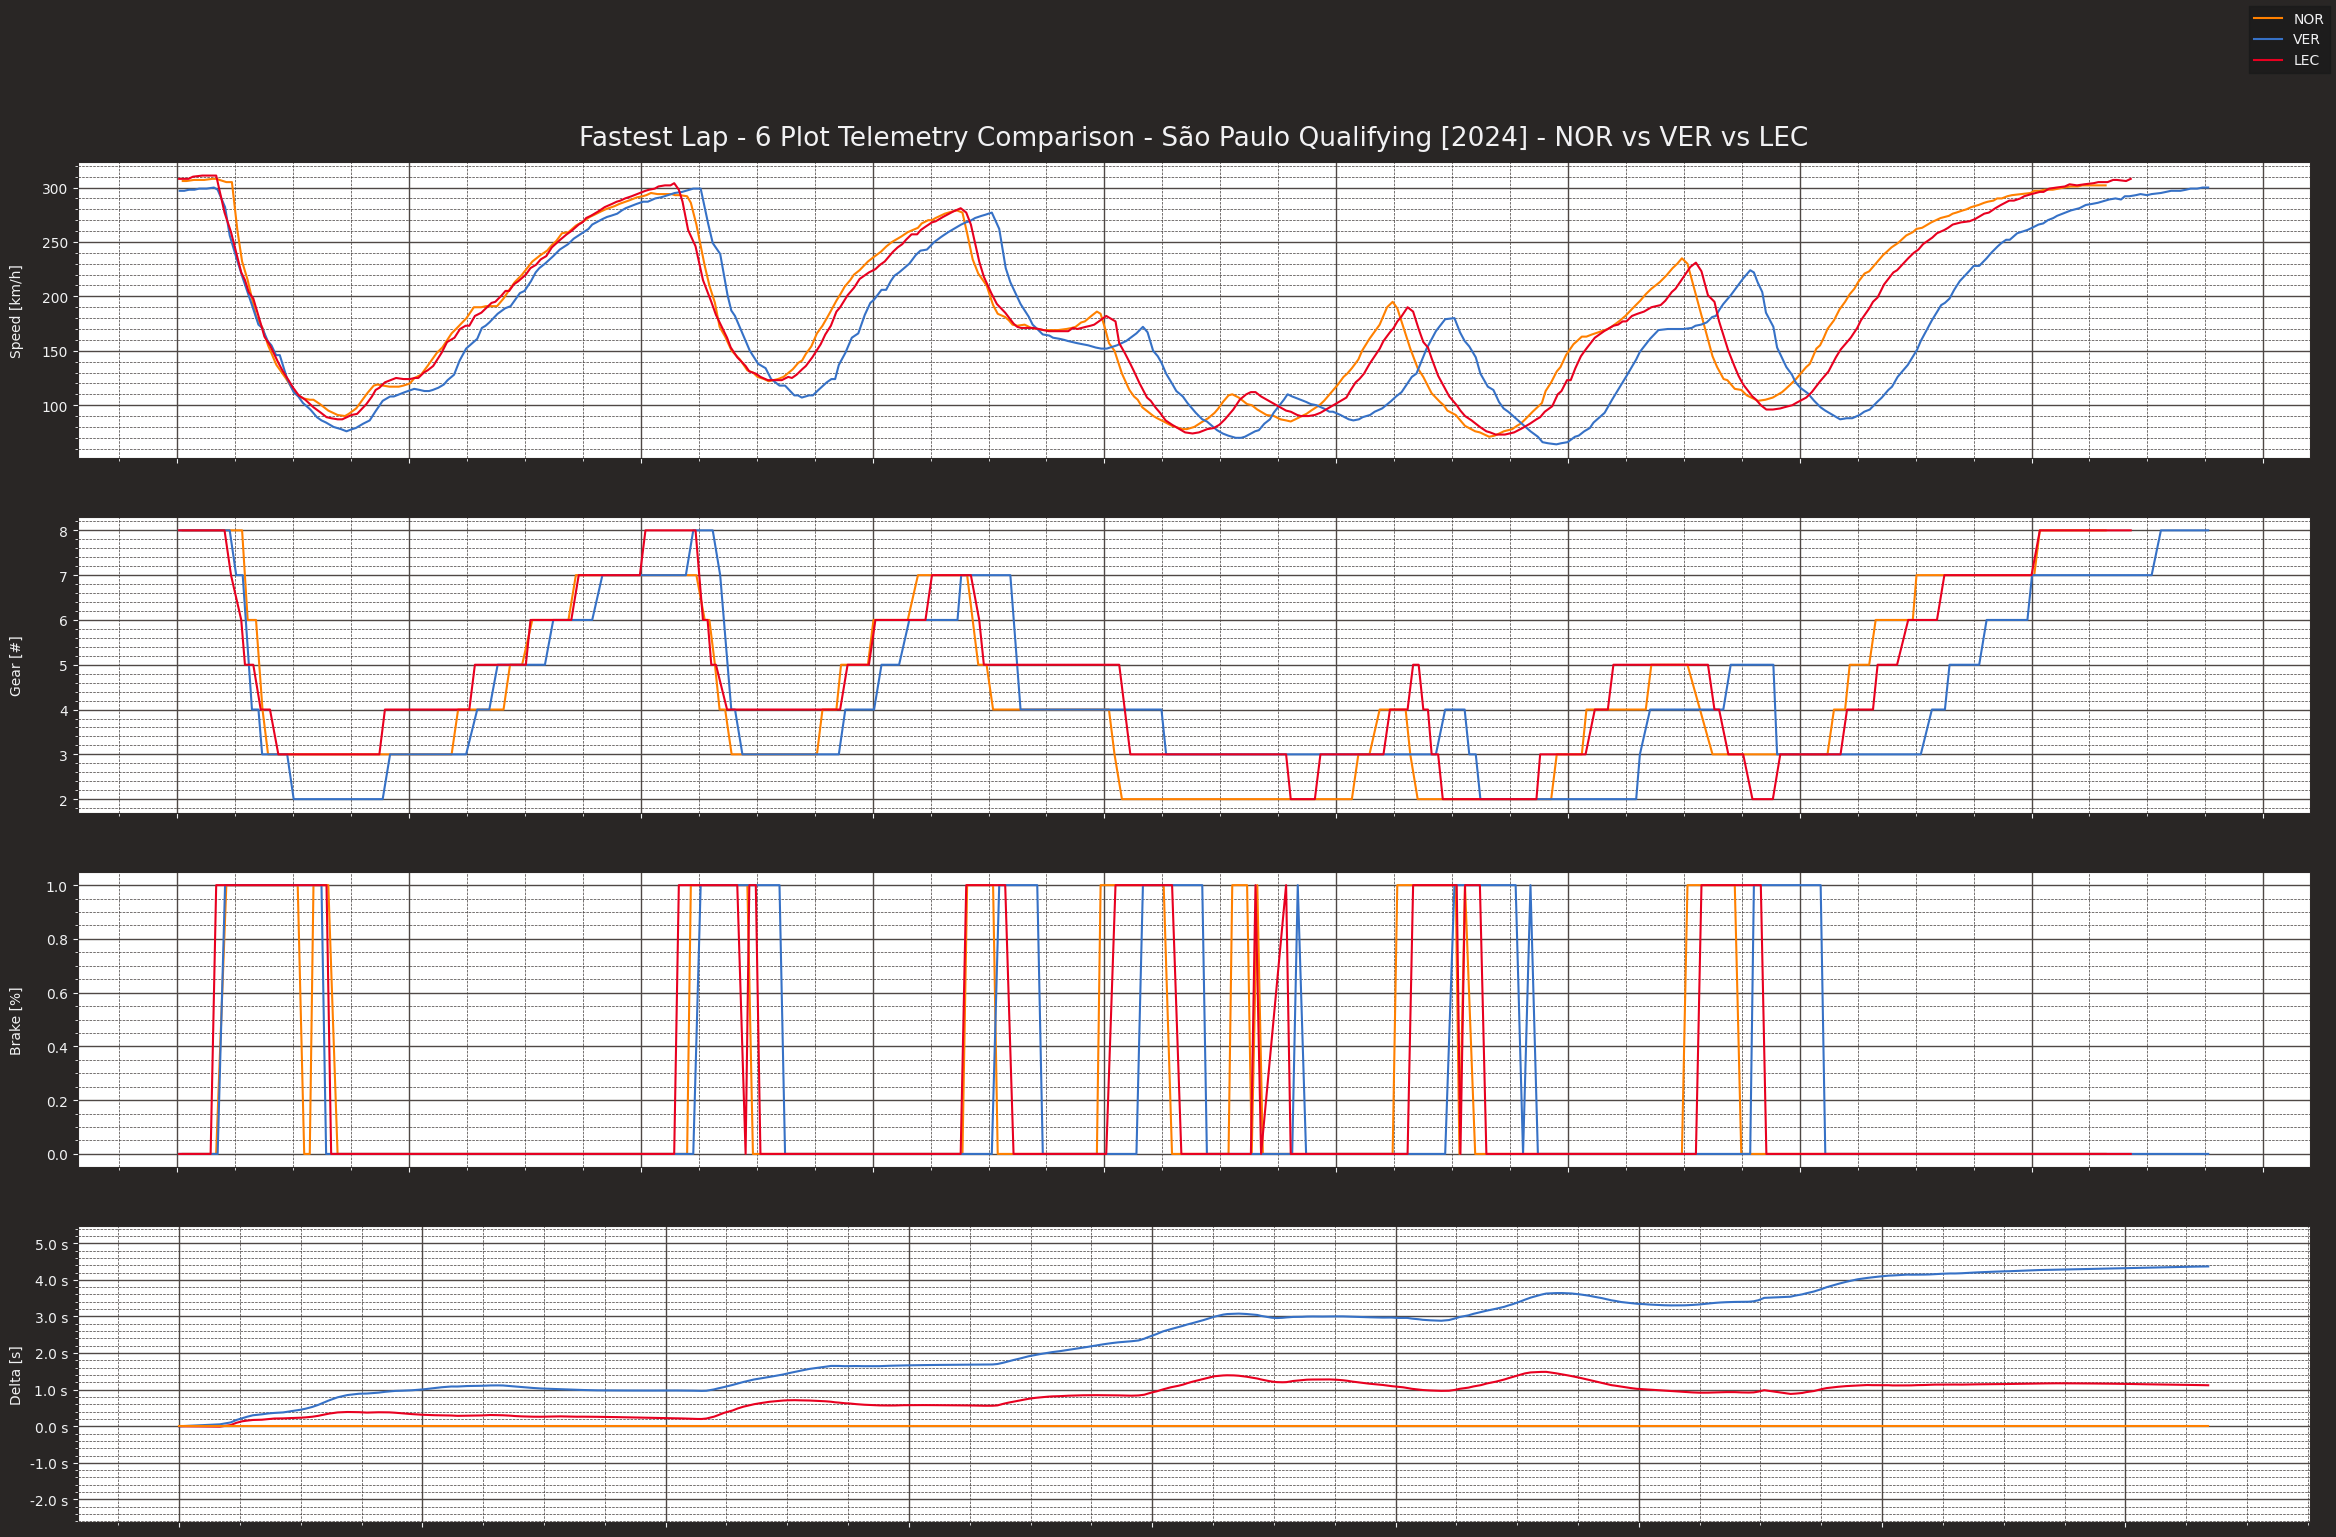

In [32]:
# Plot Telemetry
plotting.setup_mpl(color_scheme='fastf1')

subplots_number = 4 # Adjust to match number of plots included
fig, ax = plt.subplots(subplots_number,figsize=(24,16))

background = "white"
title_color = 'silver' # '#6441a5'

ax[0].set_facecolor(background)
ax[1].set_facecolor(background)
ax[2].set_facecolor(background)
ax[3].set_facecolor(background)
# ax[4].set_facecolor(background)
# ax[5].set_facecolor(background)
# ax[6].set_facecolor(background)


ax[0].plot(telemetry_driver_1['Time'], telemetry_driver_1['Speed'], color=team_color_1, linestyle='-', label=driver_1)
ax[0].plot(telemetry_driver_2['Time'], telemetry_driver_2['Speed'], color=team_color_2, linestyle='-', label=driver_2)
ax[0].plot(telemetry_driver_3['Time'], telemetry_driver_3['Speed'], color=team_color_3, linestyle='-', label=driver_3)

# ax[1].plot(telemetry_driver_1['Time'], telemetry_driver_1['RPM'], color=team_color_1, linestyle='-', label=driver_1)
# ax[1].plot(telemetry_driver_2['Time'], telemetry_driver_2['RPM'], color=team_color_2, linestyle='-', label=driver_2)
# ax[1].plot(telemetry_driver_3['Time'], telemetry_driver_3['RPM'], color=team_color_3, linestyle='-', label=driver_3)

ax[1].plot(telemetry_driver_1['Time'], telemetry_driver_1['nGear'], color=team_color_1, linestyle='-', label=driver_1)
ax[1].plot(telemetry_driver_2['Time'], telemetry_driver_2['nGear'], color=team_color_2, linestyle='-', label=driver_2)
ax[1].plot(telemetry_driver_3['Time'], telemetry_driver_3['nGear'], color=team_color_3, linestyle='-', label=driver_3)

# ax[3].plot(telemetry_driver_1['Time'], telemetry_driver_1['Throttle'], color=team_color_1, linestyle='-', label=driver_1)
# ax[3].plot(telemetry_driver_2['Time'], telemetry_driver_2['Throttle'], color=team_color_2, linestyle='-', label=driver_2)
# ax[3].plot(telemetry_driver_3['Time'], telemetry_driver_3['Throttle'], color=team_color_3, linestyle='-', label=driver_3)

ax[2].plot(telemetry_driver_1['Time'], telemetry_driver_1['Brake'], color=team_color_1, linestyle='-', label=driver_1)
ax[2].plot(telemetry_driver_2['Time'], telemetry_driver_2['Brake'], color=team_color_2, linestyle='-', label=driver_2)
ax[2].plot(telemetry_driver_3['Time'], telemetry_driver_3['Brake'], color=team_color_3, linestyle='-', label=driver_3)

# ax[5].plot(telemetry_driver_1['Time'], telemetry_driver_1['DRS'], color=team_color_1, linestyle='-', label=driver_1)
# ax[5].plot(telemetry_driver_2['Time'], telemetry_driver_2['DRS'], color=team_color_2, linestyle='-', label=driver_2)

# Plot Delta Time with centered y-axis in seconds
ax[3].plot(ref_tel['Time'], delta_time_seconds_1, color=delta_line_color_1, linestyle='-', label=f"Delta Time ({compare_driver_1} vs {ref_driver})")
ax[3].plot(ref_tel['Time'], delta_time_seconds_2, color=delta_line_color_2, linestyle='-', label=f"Delta Time ({compare_driver_2} vs {ref_driver})")
ax[3].plot(ref_tel['Time'], np.zeros_like(ref_tel['Time']), color=base_line_color, linestyle='-', label=f"{ref_driver} (faster)")
ax[3].set_ylim(-y_lower_limit, y_upper_limit)  # Center y-axis around 0 with 20% margin
ax[3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f} s"))

ax[0].set_ylabel("Speed [km/h]")
# ax[1].set_ylabel("RPM [#]")
ax[1].set_ylabel("Gear [#]")
# ax[3].set_ylabel("Throttle [%]")
ax[2].set_ylabel("Brake [%]")
# ax[5].set_ylabel("DRS")
ax[3].set_ylabel("Delta [s]")

ax[0].get_xaxis().set_ticklabels([])
ax[1].get_xaxis().set_ticklabels([])
ax[2].get_xaxis().set_ticklabels([])
ax[3].get_xaxis().set_ticklabels([])
# ax[4].get_xaxis().set_ticklabels([])
# ax[5].get_xaxis().set_ticklabels([])
# ax[6].get_xaxis().set_ticklabels([])

fig.align_ylabels()

fig.legend([driver_1,driver_2, driver_3])


plot_title = 'Fastest Lap - 6 Plot Telemetry Comparison - '+grand_prix+' '+session_type+' ['+str(year)+'] - '+driver_1+' vs '+driver_2+' vs '+driver_3
ax[0].title.set_text(plot_title)
plt.subplots_adjust(left=0.06 ,right=0.99, top=0.9, bottom=0.05)

year_str = str(year)

# UPDATE - save plot, year
file_name = '/Users/charlotte/Desktop/'+driver_1+'-vs-'+driver_2+'-vs-'+driver_3+'_'+grand_prix+'_'+session_type+'_driver-telemetry-comparison'+year_str+'.png'
plt.savefig(file_name, dpi=300)  # bbox_inches='tight'